In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import community as community_louvain

#### Из предложенных графов выбрала Karate Club, где: вершины - участники клуба; рёбра - социальные взаимодействия; граф неориентированный и невзвешенный. Также известно, что граф разделен на два условных сообщества.

In [6]:
G = nx.karate_club_graph()

## Базовый анализ

In [12]:
def basic_graph_metrics(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_degree": np.mean([d for _, d in G.degree()]),
        "avg_clustering": nx.average_clustering(G),
        "transitivity" : nx.transitivity(G),
        "connected": nx.is_connected(G)
    }

metrics = basic_graph_metrics(G)
metrics


{'num_nodes': 34,
 'num_edges': 78,
 'density': 0.13903743315508021,
 'avg_degree': 4.588235294117647,
 'avg_clustering': 0.5706384782076823,
 'transitivity': 0.2556818181818182,
 'connected': True}

#### Коэфициент средней кластеризации характерезует это граф как социальную сеть: ~0.57. Рефернсное значение для социальной сети: 0.3-0.6.
#### Средняя степень вершины ~ 4.59. Следовательно каждый учатстиник имеет около 4-5 социальных связей.
#### Транзитивность ~ 0.256. Есть внутренние сообщества,  и они выражены сильнее, чем связность всей группы.

### Распределение степеней вершин

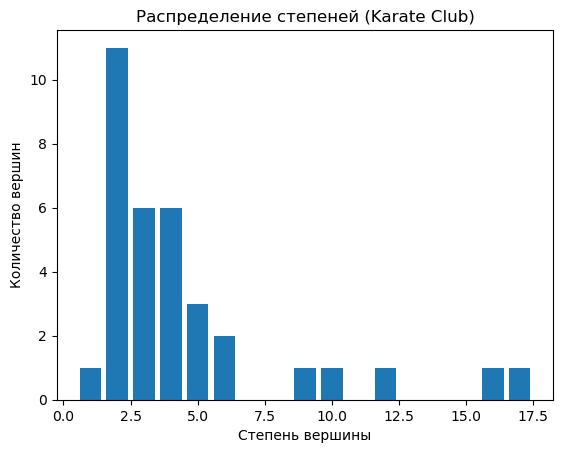

In [11]:
degrees = [d for _, d in G.degree()]
degree_counts = Counter(degrees)

plt.figure()
plt.bar(degree_counts.keys(), degree_counts.values())
plt.xlabel("Степень вершины")
plt.ylabel("Количество вершин")
plt.title("Распределение степеней (Karate Club)")
plt.show()

#### Распределение неравномерное, присутствуют вершины с большим количеством связей, что характерно для социальных сетей.

## Анализ центральности

In [14]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [15]:
def top_nodes(centrality_dict, top_n=5):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

print("Degree(Популярность):", top_nodes(degree_centrality))
print("Betweenness(Посредники):", top_nodes(betweenness_centrality))
print("Closeness(Близость):", top_nodes(closeness_centrality))
print("Eigenvector(Влияние через связи):", top_nodes(eigenvector_centrality))

Degree: [(33, 0.5151515151515151), (0, 0.48484848484848486), (32, 0.36363636363636365), (2, 0.30303030303030304), (1, 0.2727272727272727)]
Betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114), (2, 0.14365680615680618), (31, 0.13827561327561325)]
Closeness: [(0, 0.5689655172413793), (2, 0.559322033898305), (33, 0.55), (31, 0.5409836065573771), (8, 0.515625)]
Eigenvector: [(33, 0.37337121301323506), (0, 0.35548349418519426), (2, 0.3171893899684447), (32, 0.3086510477336959), (1, 0.2659538704545024)]


#### Одни и те же вершины часто входят в топ по разным мерам центральности. То есть ключевые участники, которые имеют большое число связей и соединяют различные части сети.

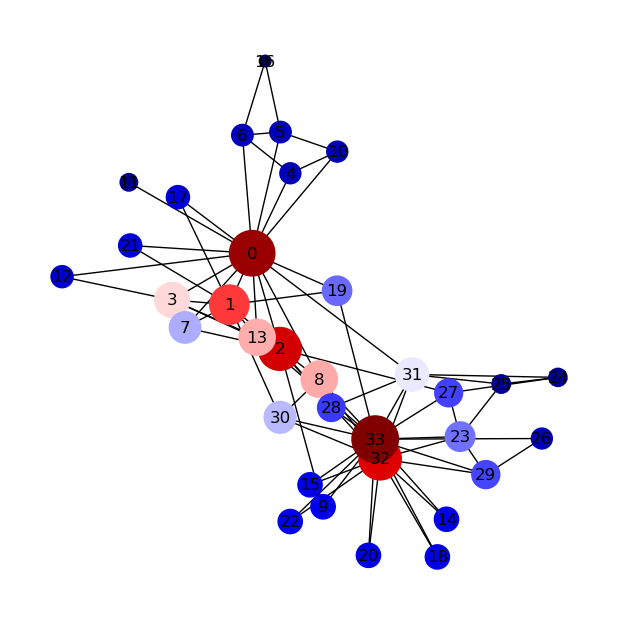

In [19]:
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)

node_sizes = [3000 * eigenvector_centrality[v] for v in G.nodes()]

nx.draw(
    G, pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=list(eigenvector_centrality.values()),
    cmap=plt.cm.seismic
)
plt.show()

#### Как раз хорошо видны вершины, которые влиют на граф.

## Обнаружение сообществ

In [31]:
partition = community_louvain.best_partition(G)

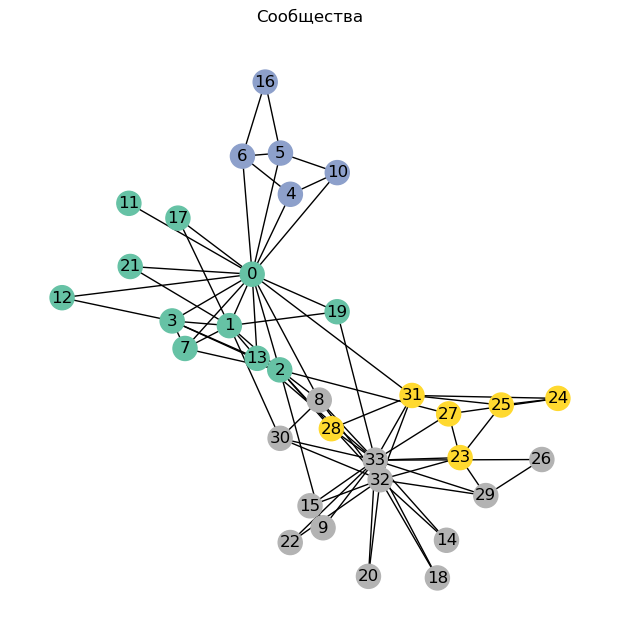

In [32]:
plt.figure(figsize=(6, 6))

communities = list(partition.values())
nx.draw(
    G, pos,
    node_color=communities,
    with_labels=True,
    cmap=plt.cm.Set2
)

plt.title("Сообщества")
plt.show()


#### По графу видно, что есть четыре локальных сообщества.

In [33]:
modularity = community_louvain.modularity(partition, G)
modularity

0.44490358126721763

#### Значение модульрност довольно высокое ~ 0.45. Следовательно сеть хорошо разделена на сообщества, есть плотные связи внутри сообщества. Что соответсвует визуализации с разделение графа на сообщества.

### Кластеризация при помощи K-Means

In [34]:
X = np.array([
    [
        degree_centrality[v],
        betweenness_centrality[v],
        closeness_centrality[v],
        eigenvector_centrality[v]
    ]
    for v in G.nodes()
])

In [49]:
for i in range(2, 5):
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    print(f"Количество кластеров: {i}. Значение метрики: {silhouette}")

Количество кластеров: 2. Значение метрики: 0.6593374874839218
Количество кластеров: 3. Значение метрики: 0.6092455330831019
Количество кластеров: 4. Значение метрики: 0.5380005096890843


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Смотря на значения метрики, становится, понятно, что следует разделить на два кластера.

In [52]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
silhouette = silhouette_score(X, labels)
silhouette

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.6593374874839218

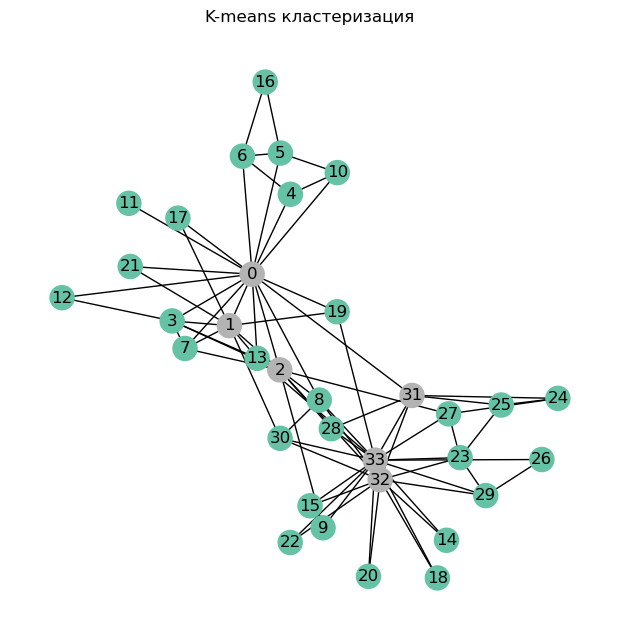

In [53]:
plt.figure(figsize=(6, 6))

nx.draw(
    G, pos,
    node_color=labels,
    with_labels=True,


    
    cmap=plt.cm.Set2
)

plt.title("K-means кластеризация")
plt.show()

#### K-Means определяет, что эта сеть имеет только два кластера, то есть две подгруппы людей.